# RNN POS Tagger

This example trains a RNN to tag words from a corpus.

In [1]:
import numpy as np
import os

## Use the Brown Corpus

In [2]:
from nltk.corpus import brown

Get the tokenized and tagged with Universal POS sentences from the "news" category.

In [3]:
tagged_sentences = brown.tagged_sents(tagset='universal', categories='news')
MAX_LENGTH = len(max(tagged_sentences, key=len))

Collect the tag set and word set

In [4]:
tags = set([tag for sent in tagged_sentences for (token,tag) in sent])

tag2index = {t:i+1 for i,t in enumerate(tags)} # leave 0 for PAD
tag2index['-PAD-'] = 0  # The special value used to padding

idx2tag = list(tag2index.keys())

TAGSET_SIZE = len(tag2index)

In [5]:
words = set([w.lower() for sent in tagged_sentences for w,t in sent])

# Add entries for pad and unknown words
word2index = {w: i + 2 for i, w in enumerate(words)}
word2index['-PAD-'] = 0  # The special value used for padding
word2index['-OOV-'] = 1  # The special value used for OOVs

## An RNN Part-of-Speech Tagger

### Build dataset


Split into train and test

In [6]:
from sklearn.model_selection import train_test_split
tagged_train, tagged_test = train_test_split(tagged_sentences, test_size=0.2, random_state=42)

Separate words from tags

In [7]:
x_train = [ [word2index[w.lower()] for w,t in s] for s in tagged_train]
y_train = [ [tag2index[t] for w,t in s] for s in tagged_train]

x_test = [ [word2index[w.lower()] for w,t in s] for s in tagged_test]
y_test = [ [tag2index[t] for w,t in s] for s in tagged_test]

Pad sentences

In [8]:
from keras.preprocessing.sequence import pad_sequences
 
x_train = pad_sequences(x_train, maxlen=MAX_LENGTH, padding='post')
y_train = pad_sequences(y_train, maxlen=MAX_LENGTH, padding='post')
x_test = pad_sequences(x_test, maxlen=MAX_LENGTH, padding='post')
y_test = pad_sequences(y_test, maxlen=MAX_LENGTH, padding='post')

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.8) or chardet (4.0.0) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


# Define the RNN

#### Good blog post series
*  http://www.wildml.com/2015/10/recurrent-neural-network-tutorial-part-4-implementing-a-grulstm-rnn-with-python-and-theano/

#### Keras Examples
*  https://github.com/fchollet/keras/issues/5022

#### Keras RNN
*  https://keras.io/layers/recurrent/


In [9]:
from tensorflow.keras.layers import Input, Embedding, GRU, Dense
from tensorflow.keras.layers import Bidirectional, TimeDistributed
from tensorflow.keras.models import Model, Sequential

### Build the layers
We will use a GRU RNN, which uses cells of this type:<br />
<img src="../image/GRU.png" width="400"/>

In [10]:
EMBEDDING_DIM = 50

RNN_HIDDEN_SIZE = 50

model = Sequential()

#### Masking
All our samples have a uniform length, but the model must be informed that some timesteps are actually padding and should be ignored.
This is done with masking, e.g. with parameter `mask_zero=True` to the `Embedding` layer.

model.add(Embedding(word_embeddings.shape[0],
                    word_embeddings.shape[1],
                    weights=[word_embeddings],
                    input_length=MAX_LENGTH,
                    #trainable=False, # do not update when training
                    mask_zero=True,  # 0 padding in input must be ignored
                    name="SentencesEmbedded"))

In [11]:
model.add(Embedding(len(word2index), EMBEDDING_DIM, input_length=MAX_LENGTH,
                   mask_zero=True)) # 0-padding should be masked out

Gated Recurrent Unit

In [12]:
model.add(Bidirectional(GRU(RNN_HIDDEN_SIZE, return_sequences=True,
                           dropout=0.1),
                        merge_mode='concat'))

Fully connected layer. <br/>
`TimeDistributed`, since we want an output for each token, i.e. element in the sequence.
<br/>
Input size will be RNN_HIDDEN_SIZE*2 because the bidirectional GRU are concatenated.

In [13]:
model.add(TimeDistributed(Dense(TAGSET_SIZE, activation='softmax'), 
                          name='POS-class'))

Show the model:

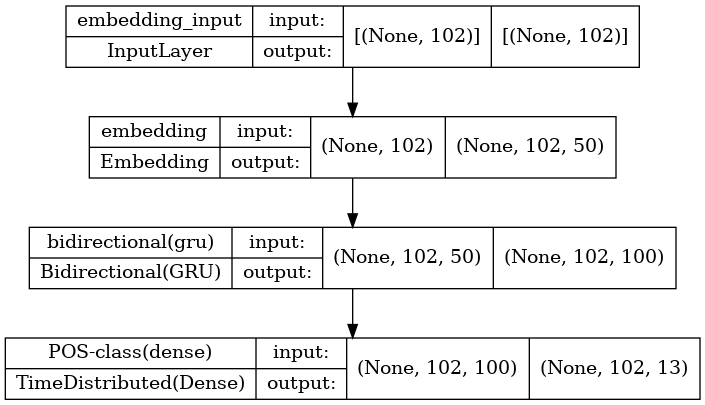

In [14]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True)

### Loss Function for Training

Padding is excluded when computing loss with mask_zero=True.

In [15]:
from tensorflow.keras.optimizers import Adam

model.compile(loss='categorical_crossentropy', optimizer=Adam(0.001), #optimizer="adam",
              metrics=['accuracy'])

### Training phase for the RNN

This will actually **train** the RNN - which can take 3-5 minutes (depending on your CPU).

In [16]:
EPOCHS = 4

BATCH_SIZE = 32

In [17]:
from tensorflow.keras.utils import to_categorical

In [18]:
history = model.fit(x_train, to_categorical(y_train, TAGSET_SIZE), batch_size=BATCH_SIZE, epochs=EPOCHS, validation_split=0.2)

Epoch 1/4
93/93 [==============================] - 22s 151ms/step - loss: 0.4013 - accuracy: 0.4231 - val_loss: 0.2295 - val_accuracy: 0.7166
Epoch 2/4
93/93 [==============================] - 12s 125ms/step - loss: 0.1233 - accuracy: 0.8442 - val_loss: 0.0730 - val_accuracy: 0.9106
Epoch 3/4
93/93 [==============================] - 11s 123ms/step - loss: 0.0436 - accuracy: 0.9494 - val_loss: 0.0469 - val_accuracy: 0.9382
Epoch 4/4
93/93 [==============================] - 12s 124ms/step - loss: 0.0232 - accuracy: 0.9733 - val_loss: 0.0402 - val_accuracy: 0.9437


In [19]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

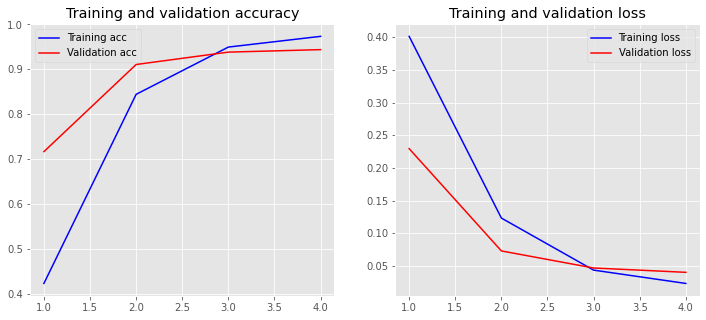

In [20]:
plot_history(history)

### Check that the Tagger Network 'works'

In [21]:
def tag_sentence(tagged_sentence):
    indices = pad_sequences([[word2index.get(w.lower(), 1) for w,t in tagged_sentence]],
                            maxlen=MAX_LENGTH, padding='post')
    output = model.predict(indices)
    print("Format: WORD/GOLD/PREDICTED\n")
    # output is a softmax-vector for each word
    annotated = ["%s/%d/%d" % (w, tag2index[t], np.argmax(output[0, i]))
                    for i, (w,t) in enumerate(tagged_sentence) ]
    return ' '.join(annotated)

A sentence from the test set:

In [22]:
tag_sentence(tagged_test[0])

Format: WORD/GOLD/PREDICTED



'Seats/7/7 on/2/2 square/7/7'

## Evaluate

In [23]:
score, acc = model.evaluate(x_test, to_categorical(y_test, TAGSET_SIZE),
                            batch_size=BATCH_SIZE)
print('Test score:', score)
print('Test accuracy:', acc)

29/29 [==============================] - 1s 26ms/step - loss: 0.0405 - accuracy: 0.9441
Test score: 0.040545154362916946
Test accuracy: 0.9440767168998718


Predict results from model

In [24]:
y_logits = model.predict(x_test)
y_pred = y_logits.argmax(axis=2)

In [25]:
def remove_padding(x, y):
    """Use 0-s in x to drop paddings in y.
    Can't just use y, since it might have incorrectly predicted a 0.
    """
    return [yi for xi,yi in zip(x, y) if xi != 0]

### Show the confusion matrix

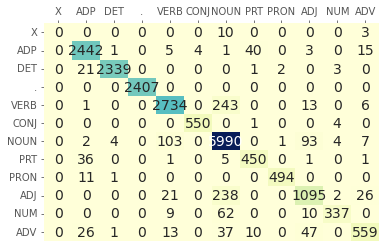

In [26]:
from sklearn.metrics import confusion_matrix

y_test_flat = remove_padding(y_test.flatten(), y_test.flatten())
y_pred_flat = remove_padding(y_test.flatten(), y_pred.flatten())

cm = confusion_matrix(y_test_flat, y_pred_flat)

import seaborn as sn
import pandas as pd
%matplotlib inline

df = pd.DataFrame(cm, index=tags, columns=tags)
ax = sn.heatmap(df, annot=True, cbar=False, fmt="d", cmap="YlGnBu", annot_kws={"size": 14})# font size
ax.xaxis.tick_top() # x axis on top

In [33]:
from sklearn.metrics import classification_report

print(classification_report([idx2tag[i] for i in y_test_flat],
                            [idx2tag[i] for i in y_pred_flat], digits=4, zero_division=0))

              precision    recall  f1-score   support

       -PAD-     0.9060    0.8066    0.8534       693
           .     0.9970    0.9886    0.9928      2366
         ADJ     0.9940    0.9763    0.9850       506
         ADP     0.0000    0.0000    0.0000        13
         ADV     0.9629    0.8062    0.8776       418
        CONJ     0.9473    0.9122    0.9295      2997
         DET     0.9618    0.9725    0.9671      2511
        NOUN     0.9928    0.9910    0.9919       555
         NUM     0.8677    0.7923    0.8283      1382
        PRON     0.8964    0.9109    0.9036       494
         PRT     0.9095    0.9655    0.9367      6204
        VERB     1.0000    1.0000    1.0000      2407

    accuracy                         0.9441     20546
   macro avg     0.8696    0.8435    0.8555     20546
weighted avg     0.9437    0.9441    0.9432     20546



### Exercises

1.  Use pretrained embeddings.
1.  See whether more advanced 'LSTM' nodes would improve the scores
1.  Add a special 'is_uppercase' element to the embedding vector (or, more simply, just replace one of the elements with an indicator).  Does this help the NNP accuracy?